Uzair Khan

--- Processing AAPL ---

=== Daily Analysis ===
Short-term trend bullish: MA20 (253.15) > MA50 (240.42)


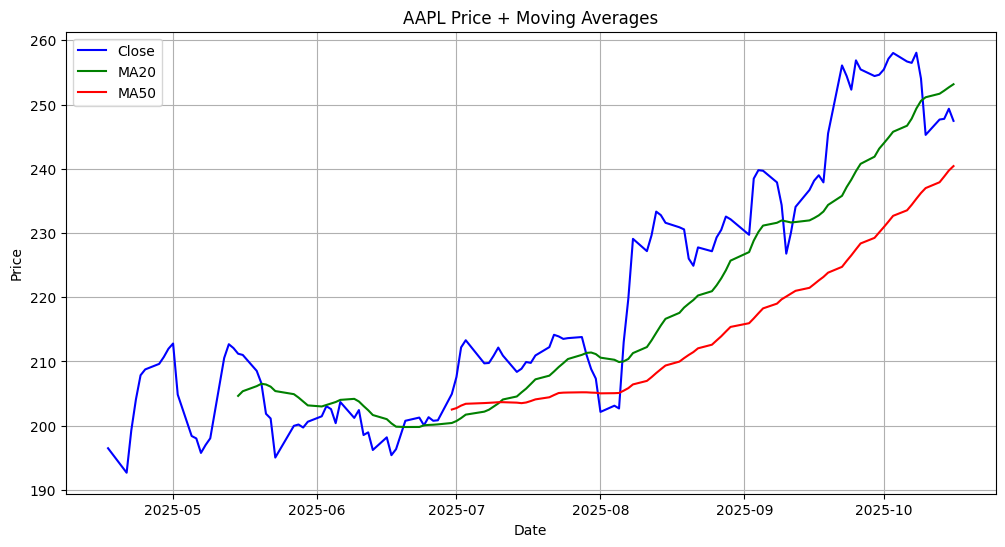


=== Intraday Sample (5min) ===
             Datetime    Open    High     Low   Close  Volume
0 2025-10-16 19:55:00  246.35  247.00  246.30  246.35  3326.0
1 2025-10-16 19:50:00  246.70  246.75  246.30  246.36   863.0
2 2025-10-16 19:45:00  246.26  247.00  246.26  246.30  2422.0
3 2025-10-16 19:40:00  246.40  246.50  246.26  246.26  1088.0
4 2025-10-16 19:35:00  246.30  246.45  246.01  246.35  2265.0


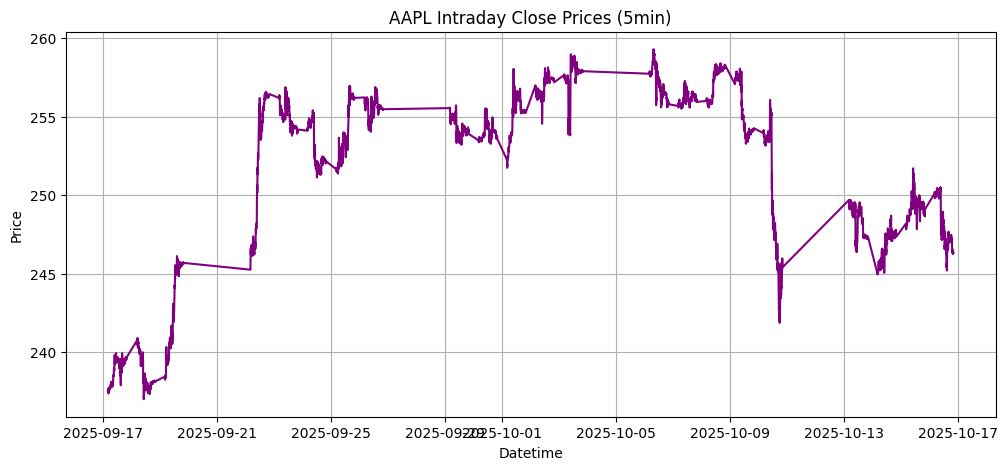


Memory stored for agent: {'last_close': 247.4499969482422, 'MA20': 253.15349884033202, 'MA50': 240.41501068115235, 'insight': 'Short-term trend bullish: MA20 (253.15) > MA50 (240.42)', 'timestamp': '2025-10-17 04:29:22'}
Memory file saved: AAPL_memory.json


In [ ]:
# ===============================================
# # Agentic AI Investment Research Notebook
# ===============================================

# ## 1. Setup Libraries
!pip install yfinance alpha_vantage pandas matplotlib numpy --quiet

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import json
import os

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# ===============================================
# ## 2. Define Price Agent
# Fetches daily history and optional intraday data
# ===============================================
class PriceAgent:
    def __init__(self, alpha_key=None):
        self.alpha_key = alpha_key
        if alpha_key:
            self.ts = TimeSeries(key=alpha_key, output_format='pandas')
        self.memory = {}  # stores past insights

    def fetch_history(self, symbol, period='6mo', interval='1d'):
        # Download historical prices
        df = yf.download(symbol, period=period, interval=interval, progress=False)
        df.reset_index(inplace=True)

        # Flatten MultiIndex columns if present
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in df.columns]

        # Rename for consistency
        for col in ['Close', 'Open', 'High', 'Low', 'Volume']:
            if f"{col}_{symbol}" in df.columns:
                df.rename(columns={f"{col}_{symbol}": col}, inplace=True)
        return df

    def fetch_intraday(self, symbol, interval='5min'):
        if not self.alpha_key:
            raise ValueError("Alpha Vantage API key not provided.")
        data, meta = self.ts.get_intraday(symbol=symbol, interval=interval, outputsize='full')
        data.reset_index(inplace=True)
        data.columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']
        return data

# ===============================================
# ## 3. Define Analysis Agent
# Computes indicators and trend insights
# ===============================================
class AnalysisAgent:
    def __init__(self, memory=None):
        self.memory = memory if memory else {}

    def compute_indicators(self, df):
        df['MA20'] = df['Close'].rolling(20).mean()
        df['MA50'] = df['Close'].rolling(50).mean()
        return df

    def analyze_trend(self, df):
        latest = df.iloc[-1]
        insight = "Neutral"
        if latest['MA20'] > latest['MA50']:
            insight = f"Short-term trend bullish: MA20 ({latest['MA20']:.2f}) > MA50 ({latest['MA50']:.2f})"
        else:
            insight = f"Short-term trend bearish: MA20 ({latest['MA20']:.2f}) < MA50 ({latest['MA50']:.2f})"
        self.memory['last_close'] = float(latest['Close'])
        self.memory['MA20'] = float(latest['MA20'])
        self.memory['MA50'] = float(latest['MA50'])
        self.memory['insight'] = insight
        self.memory['timestamp'] = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
        return insight

# ===============================================
# ## 4. Define Orchestrator
# Coordinates PriceAgent + AnalysisAgent
# ===============================================
class Orchestrator:
    def __init__(self, alpha_key=None):
        self.price_agent = PriceAgent(alpha_key)
        self.analysis_agent = AnalysisAgent()

    def run(self, symbol, history_period='6mo', intraday_interval='5min', do_intraday=True):
        print(f"--- Processing {symbol} ---")

        # Fetch daily historical data
        hist = self.price_agent.fetch_history(symbol, period=history_period)
        hist = self.analysis_agent.compute_indicators(hist)
        insight = self.analysis_agent.analyze_trend(hist)

        print("\n=== Daily Analysis ===")
        print(insight)

        # Plot historical trends
        plt.figure(figsize=(12,6))
        plt.plot(hist['Date'], hist['Close'], label='Close', color='blue')
        plt.plot(hist['Date'], hist['MA20'], label='MA20', color='green')
        plt.plot(hist['Date'], hist['MA50'], label='MA50', color='red')
        plt.title(f"{symbol} Price + Moving Averages")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.show()

        #  Optional intraday analysis
        if do_intraday and self.price_agent.alpha_key:
            intraday = self.price_agent.fetch_intraday(symbol, interval=intraday_interval)
            print(f"\n=== Intraday Sample ({intraday_interval}) ===")
            print(intraday.head(5))

            # Plot intraday close prices
            plt.figure(figsize=(12,5))
            plt.plot(pd.to_datetime(intraday['Datetime']), intraday['Close'], color='purple')
            plt.title(f"{symbol} Intraday Close Prices ({intraday_interval})")
            plt.xlabel("Datetime")
            plt.ylabel("Price")
            plt.grid(True)
            plt.show()

        #  Store memory for iterative learning
        mem_file = f"{symbol}_memory.json"
        with open(mem_file, 'w') as f:
            json.dump(self.analysis_agent.memory, f, indent=2)
        print(f"\nMemory stored for agent: {self.analysis_agent.memory}")
        print(f"Memory file saved: {mem_file}")

        return {
            'history': hist,
            'insight': insight,
            'memory': self.analysis_agent.memory
        }

# ===============================================
# ## 5. Run the Orchestrator
# ===============================================
ALPHA_KEY = "P7QOJ4OL0OMEIAS1"
orch = Orchestrator(alpha_key=ALPHA_KEY)
res = orch.run("AAPL", history_period='6mo', intraday_interval='5min', do_intraday=True)


In [ ]:
# Utilities: flattening, now iso, save/load json
from datetime import timezone
import math, statistics, pathlib

def now_iso():
    return datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")

def flatten_yf(df, symbol=None):
    # flatten multiindex columns if present; make sure 'Close','Open' exist
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [f"{c[0]}_{c[1]}" if c[1] else c[0] for c in df.columns]
    # if single ticker returns 'Close' or 'Close_SYMBOL'
    if symbol:
        for col in ['Close','Open','High','Low','Volume','Adj Close']:
            candidate = f"{col}_{symbol}"
            if candidate in df.columns and col not in df.columns:
                df.rename(columns={candidate: col}, inplace=True)
    return df

def save_json(obj, path):
    pathlib.Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path,'w') as f:
        json.dump(obj, f, indent=2)

def load_json(path):
    p = pathlib.Path(path)
    if p.exists():
        return json.load(open(p))
    return None


In [ ]:
class IndicatorAgent:
    def __init__(self):
        pass

    def add_indicators(self, df):
        # ensure Close exists
        if 'Close' not in df.columns:
            raise KeyError("DataFrame must have Close column before indicators.")
        df = df.copy()
        df['MA20'] = df['Close'].rolling(20).mean()
        df['MA50'] = df['Close'].rolling(50).mean()
        # RSI 14
        delta = df['Close'].diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        roll_up = up.rolling(14).mean()
        roll_down = down.rolling(14).mean()
        rs = roll_up / roll_down
        df['RSI14'] = 100 - (100 / (1 + rs))
        # MACD (12/26) + signal(9)
        ema12 = df['Close'].ewm(span=12, adjust=False).mean()
        ema26 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = ema12 - ema26
        df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
        # realized vol (21d annualized)
        df['Return'] = df['Close'].pct_change()
        df['RealizedVol21'] = df['Return'].rolling(21).std() * (252**0.5)
        return df


In [ ]:
class EvaluatorAgent:
    """
    Produces a conviction score (0-100) combining:
      - MA alignment (MA20 vs MA50)
      - MACD direction
      - RSI normalization
      - Volatility penalty
    Also contains a tiny backtest: percent of MA crossover signals that were correct over last N days.
    """
    def __init__(self):
        pass

    def conviction_score(self, df):
        # defensive checks
        if df[['MA20','MA50']].dropna().empty:
            return 50.0
        latest = df.dropna(subset=['MA20','MA50']).iloc[-1]
        score = 50.0
        # MA alignment
        if latest['MA20'] > latest['MA50']:
            score += 15
        else:
            score -= 15
        # MACD
        if 'MACD' in df.columns and 'MACD_signal' in df.columns:
            l = df.dropna(subset=['MACD','MACD_signal']).iloc[-1]
            if l['MACD'] > l['MACD_signal']:
                score += 10
            else:
                score -= 10
        # RSI: extreme hurts conviction
        if 'RSI14' in df.columns and not math.isnan(latest['RSI14']):
            r = latest['RSI14']
            if r < 30:
                score += 5
            elif r > 70:
                score -= 5
        # vol penalty
        if 'RealizedVol21' in df.columns and not math.isnan(latest['RealizedVol21']):
            vol = latest['RealizedVol21']
            score -= min(20, vol*10)  # crude scale
        return float(max(0, min(100, score)))

    def ma_crossover_accuracy(self, df, lookback_days=90, forward_days=5):
        """
        Backtest: every time MA20 crosses above MA50 (bull) or below (bear) in lookback window,
        check price change over forward_days. Return accuracy (percent correct direction).
        """
        df = df.copy().dropna(subset=['MA20','MA50'])
        if df.empty or len(df) < lookback_days:
            return None
        df['signal'] = 0
        df['signal'] = np.where(df['MA20'] > df['MA50'], 1, 0)
        df['cross'] = df['signal'].diff()  # 1 = cross up, -1 = cross down
        events = df[df['cross'] != 0].tail(lookback_days)
        if events.empty:
            return None
        correct = 0
        total = 0
        for idx, row in events.iterrows():
            idx_loc = df.index.get_loc(idx)
            if idx_loc + forward_days < len(df):
                future_price = df['Close'].iloc[idx_loc + forward_days]
                direction = 1 if row['cross'] == 1 else -1
                ret = (future_price - row['Close'])/row['Close']
                if direction == 1 and ret > 0:
                    correct += 1
                if direction == -1 and ret < 0:
                    correct += 1
                total += 1
        return None if total==0 else (correct/total)


In [ ]:
class Optimizer:
    def __init__(self, price_agent, indicator_agent, evaluator, max_iters=4, conv_threshold=60.0):
        self.price_agent = price_agent
        self.indicator_agent = indicator_agent
        self.evaluator = evaluator
        self.max_iters = max_iters
        self.conv_threshold = conv_threshold

    def optimize(self, symbol, base_history='6mo'):
        # candidate parameter sets: list of (ma_short, ma_long, history)
        candidates = [
            (20,50, base_history),
            (10,30, base_history),
            (30,80, '1y'),
            (5,20,'3mo')
        ]
        best = None
        runs = []
        for (ma_s, ma_l, histp) in candidates[:self.max_iters]:
            df = self.price_agent.fetch_history(symbol, period=histp)
            # compute custom MAs
            df['MA_short_custom'] = df['Close'].rolling(ma_s).mean()
            df['MA_long_custom'] = df['Close'].rolling(ma_l).mean()
            # add other indicators
            df = self.indicator_agent.add_indicators(df)
            conv = self.evaluator.conviction_score(df)
            acc = self.evaluator.ma_crossover_accuracy(df)
            runs.append({'ma_s':ma_s,'ma_l':ma_l,'history':histp,'conviction':conv,'ma_accuracy':acc})
            if best is None or conv>best['conviction']:
                best = runs[-1]
        return {'runs':runs,'best':best}


In [ ]:
class MemoryAgent:
    def __init__(self, path="agent_memory.json"):
        self.path = path
        v = load_json(path)
        if v is None:
            v = {'runs':[]}
        self.mem = v

    def append(self, symbol, report):
        self.mem['runs'].append({'symbol':symbol,'timestamp':now_iso(),'report':report})
        # keep last 200
        self.mem['runs'] = self.mem['runs'][-200:]
        save_json(self.mem, self.path)

    def get_all(self):
        return self.mem

# Prompt chaining: ingest->preprocess->classify->extract->summarize
def prompt_chain_single(symbol, price_agent, indicator_agent, evaluator, optimizer=None, do_intraday=False):
    # ingest
    hist = price_agent.fetch_history(symbol)
    # preprocess & flatten already done
    # compute indicators
    hist = indicator_agent.add_indicators(hist)
    # classify (MA relationship)
    latest = hist.dropna(subset=['MA20','MA50']).iloc[-1]
    if latest['MA20'] > latest['MA50']:
        classification = 'bullish'
    else:
        classification = 'bearish'
    # extract
    extracted = {
        'last_close': float(latest['Close']),
        'MA20': float(latest['MA20']),
        'MA50': float(latest['MA50']),
        'RSI14': float(latest['RSI14']) if not math.isnan(latest['RSI14']) else None,
        'RealizedVol21': float(latest['RealizedVol21']) if not math.isnan(latest['RealizedVol21']) else None
    }
    # summarize (analysis)
    conv = evaluator.conviction_score(hist)
    ma_acc = evaluator.ma_crossover_accuracy(hist)
    summary = {
        'symbol': symbol,
        'classification': classification,
        'extracted': extracted,
        'conviction': conv,
        'ma_cross_accuracy': ma_acc
    }
    # optional optimizer run if conviction low
    opt_report = None
    if optimizer and conv < optimizer.conv_threshold:
        opt_report = optimizer.optimize(symbol)
        summary['optimizer'] = opt_report
    # intraday optional
    intr = None
    if do_intraday and price_agent.alpha_key:
        intr = price_agent.fetch_intraday(symbol)
        # don't compute heavy indicators on intraday here (simple plot only)
    summary['intraday_sample'] = intr.head(3).to_dict(orient='records') if intr is not None else None
    return hist, summary

# Batch runner example
def batch_run(symbols, alpha_key, memory_path="agent_memory.json", do_intraday=False):
    pa = PriceAgent(alpha_key)
    ia = IndicatorAgent()
    ev = EvaluatorAgent()
    mem = MemoryAgent(memory_path)
    opt = Optimizer(pa, ia, ev)
    reports = []
    for s in symbols:
        hist, summary = prompt_chain_single(s, pa, ia, ev, optimizer=opt, do_intraday=do_intraday)
        mem.append(s, summary)
        reports.append(summary)
    # dump summary table
    df_summary = pd.DataFrame([{
        'symbol':r['symbol'],
        'class': r['classification'],
        'conviction': r['conviction'],
        'ma_cross_accuracy': r.get('ma_cross_accuracy')
    } for r in reports])
    df_summary.to_csv("batch_summary.csv", index=False)
    return df_summary, mem.get_all()

# Run batch (3-5 stocks)
symbols = ["AAPL","MSFT","AMZN","GOOGL"]
df_summary, full_memory = batch_run(symbols, ALPHA_KEY, do_intraday=False)
df_summary


,symbol,class,conviction,ma_cross_accuracy
0,AAPL,bullish,52.469745,None
1,MSFT,bullish,53.460459,None
2,AMZN,bearish,22.457198,None
3,GOOGL,bullish,52.813079,None


In [ ]:
print("Batch summary saved to batch_summary.csv")
display(df_summary)


readme_text = """
Agentic AI Investment Research - Final Project
This repository contains a multi-agent pipeline using Yahoo Finance and Alpha Vantage.
Agents: PriceAgent, IndicatorAgent, EvaluatorAgent, Optimizer, MemoryAgent.
Workflow patterns demonstrated: Prompt Chaining, Routing, Evaluator-Optimizer.
Outputs: batch_summary.csv, agent_memory.json and individual memory files.
"""
open("README_PROJECT.txt","w").write(readme_text)
print("README_PROJECT.txt written.")


Batch summary saved to batch_summary.csv


,symbol,class,conviction,ma_cross_accuracy
0,AAPL,bullish,52.469745,None
1,MSFT,bullish,53.460459,None
2,AMZN,bearish,22.457198,None
3,GOOGL,bullish,52.813079,None


README_PROJECT.txt written.


In [ ]:
# Create outputs folder
OUTDIR = "final_outputs"
os.makedirs(OUTDIR, exist_ok=True)
print("Outdir:", OUTDIR)


Outdir: final_outputs


In [ ]:
def save_symbol_report(symbol, pa, ia, ev, mem_agent_path=None, save_intraday=False):
    # fetch fresh daily (use existing classes)
    hist = pa.fetch_history(symbol)
    hist = ia.add_indicators(hist)
    conv = ev.conviction_score(hist)
    ma_acc = ev.ma_crossover_accuracy(hist)

    # save daily plot
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(hist['Date'], hist['Close'], label='Close')
    ax.plot(hist['Date'], hist['MA20'], label='MA20')
    ax.plot(hist['Date'], hist['MA50'], label='MA50')
    ax.set_title(f"{symbol} Daily Price + MA")
    ax.legend()
    daily_png = os.path.join(OUTDIR, f"{symbol}_daily.png")
    fig.savefig(daily_png, bbox_inches='tight', dpi=150)
    plt.close(fig)

    intr_sample = None
    intr_png = None
    if save_intraday and pa.alpha_key:
        intr = pa.fetch_intraday(symbol)
        intr_sample = intr.head(20).to_dict(orient='records')
        fig, ax = plt.subplots(figsize=(10,4))
        ax.plot(pd.to_datetime(intr['Datetime']), intr['Close'])
        ax.set_title(f"{symbol} Intraday Close ({len(intr)} points)")
        intr_png = os.path.join(OUTDIR, f"{symbol}_intraday.png")
        fig.savefig(intr_png, bbox_inches='tight', dpi=150)
        plt.close(fig)

    # compose report
    latest = hist.dropna(subset=['MA20','MA50']).iloc[-1].to_dict()
    report = {
        'symbol': symbol,
        'timestamp': now_iso(),
        'latest_close': float(latest['Close']),
        'MA20': float(latest['MA20']),
        'MA50': float(latest['MA50']),
        'conviction': conv,
        'ma_cross_accuracy': ma_acc,
        'daily_plot': daily_png,
        'intraday_plot': intr_png,
        'intraday_sample': intr_sample
    }
    # save JSON + CSV (CSV = last 60 rows)
    json_path = os.path.join(OUTDIR, f"{symbol}_report.json")
    csv_path = os.path.join(OUTDIR, f"{symbol}_history_short.csv")
    save_json(report, json_path)
    hist.tail(60).to_csv(csv_path, index=False)
    return report

# run for your four symbols; reuse existing classes
pa = PriceAgent(ALPHA_KEY)
ia = IndicatorAgent()
ev = EvaluatorAgent()

reports = {}
for s in symbols:
    print("Saving report for", s)
    rpt = save_symbol_report(s, pa, ia, ev, save_intraday=False)  # change to True if you want intraday saved
    reports[s] = rpt

# Save aggregate json
save_json(reports, os.path.join(OUTDIR, "all_symbol_reports.json"))
print("Saved reports to", OUTDIR)


Saving report for AAPL
Saving report for MSFT
Saving report for AMZN
Saving report for GOOGL
Saved reports to final_outputs


In [ ]:
def backtest_ma_strategy(df, ma_short=20, ma_long=50, hold_days=5, start_capital=10000):
    df = df.copy().reset_index(drop=True)
    df['MA_s'] = df['Close'].rolling(ma_short).mean()
    df['MA_l'] = df['Close'].rolling(ma_long).mean()
    df = df.dropna(subset=['MA_s','MA_l']).reset_index(drop=True)
    if df.empty:
        return None
    # generate signal: 1 = long when MA_s > MA_l, 0 = flat/neutral
    df['signal'] = (df['MA_s'] > df['MA_l']).astype(int)
    # generate entry points when signal changes from 0->1 (buy) or 1->0 (sell)
    df['signal_shift'] = df['signal'].shift(1).fillna(df['signal'])
    df['entry'] = ((df['signal_shift'] == 0) & (df['signal'] == 1)).astype(int)
    trades = []
    for i,row in df.iterrows():
        if row['entry'] == 1 and (i + hold_days) < len(df):
            entry_price = row['Close']
            exit_price = df.loc[i+hold_days, 'Close']
            ret = (exit_price - entry_price) / entry_price
            trades.append(ret)
    if len(trades) == 0:
        return {'trades':0,'avg_ret':None,'win_rate':None,'total_return':None}
    trades = np.array(trades)
    wins = np.sum(trades > 0)
    return {
        'trades': int(len(trades)),
        'avg_ret': float(np.mean(trades)),
        'win_rate': float(wins / len(trades)),
        'total_return': float(np.prod(1+trades) - 1)
    }

# run backtest for each symbol and save
bt_results = {}
for s in symbols:
    hist = pa.fetch_history(s)
    hist = ia.add_indicators(hist)
    bt = backtest_ma_strategy(hist, ma_short=20, ma_long=50, hold_days=5)
    bt_results[s] = bt

save_json(bt_results, os.path.join(OUTDIR, "ma_backtest_results.json"))
bt_results


{'AAPL': {'trades': 1,
  'avg_ret': 9.46979699041315e-05,
  'win_rate': 1.0,
  'total_return': 9.469796990413393e-05},
 'MSFT': {'trades': 1,
  'avg_ret': -0.02175856614532008,
  'win_rate': 0.0,
  'total_return': -0.021758566145320124},
 'AMZN': {'trades': 0,
  'avg_ret': None,
  'win_rate': None,
  'total_return': None},
 'GOOGL': {'trades': 0,
  'avg_ret': None,
  'win_rate': None,
  'total_return': None}}

In [ ]:
# Build final CSV combining batch_summary, backtest, and reports
batch_df = pd.read_csv("batch_summary.csv") if os.path.exists("batch_summary.csv") else pd.DataFrame()
rows = []
for s in symbols:
    rep = reports.get(s, {})
    bt = bt_results.get(s, {})
    rows.append({
        'symbol': s,
        'classification': rep.get('classification') if 'classification' in rep else ('bullish' if rep['MA20'] > rep['MA50'] else 'bearish'),
        'conviction': rep.get('conviction'),
        'MA20': rep.get('MA20'),
        'MA50': rep.get('MA50'),
        'ma_backtest_trades': bt.get('trades') if bt else None,
        'ma_backtest_avg_ret': bt.get('avg_ret') if bt else None,
        'ma_backtest_win_rate': bt.get('win_rate') if bt else None
    })
final_df = pd.DataFrame(rows)
final_csv = os.path.join(OUTDIR, "final_report.csv")
final_df.to_csv(final_csv, index=False)
display(final_df)
print("Final CSV:", final_csv)


,symbol,classification,conviction,MA20,MA50,ma_backtest_trades,ma_backtest_avg_ret,ma_backtest_win_rate
0,AAPL,bullish,52.469745,253.153499,240.415011,1,0.000095,1.0
1,MSFT,bullish,53.460459,515.950996,512.105052,1,-0.021759,0.0
2,AMZN,bearish,22.457198,221.038001,225.731400,0,NaN,NaN
3,GOOGL,bullish,52.813079,246.623499,230.103552,0,NaN,NaN


Final CSV: final_outputs/final_report.csv


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
OUTDIR = "final_outputs"
os.makedirs(OUTDIR, exist_ok=True)

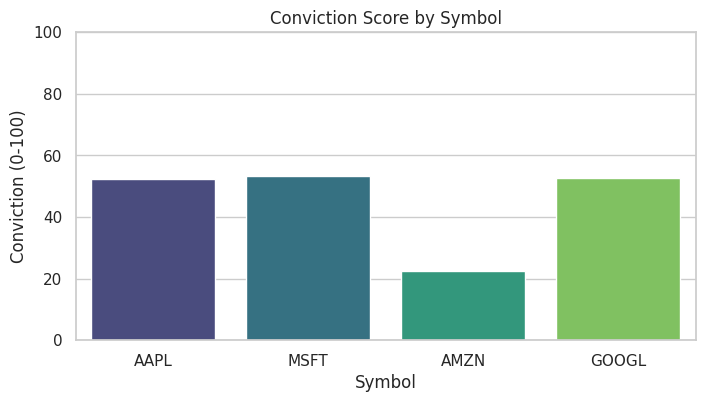

Saved: final_outputs/conviction_by_symbol.png


In [ ]:

if 'final_df' not in globals():
    if os.path.exists(os.path.join(OUTDIR,'final_report.csv')):
        final_df = pd.read_csv(os.path.join(OUTDIR,'final_report.csv'))
    elif os.path.exists("batch_summary.csv"):
        final_df = pd.read_csv("batch_summary.csv")
    else:
        final_df = None

if final_df is None:
    print("final_df not found. Please run batch summary step first.")
else:
    plt.figure(figsize=(8,4))
    sns.barplot(data=final_df, x='symbol', y='conviction', palette='viridis')
    plt.title("Conviction Score by Symbol")
    plt.ylim(0,100)
    plt.ylabel("Conviction (0-100)")
    plt.xlabel("Symbol")
    fname = os.path.join(OUTDIR, "conviction_by_symbol.png")
    plt.savefig(fname, bbox_inches='tight', dpi=150)
    plt.show()
    print("Saved:", fname)


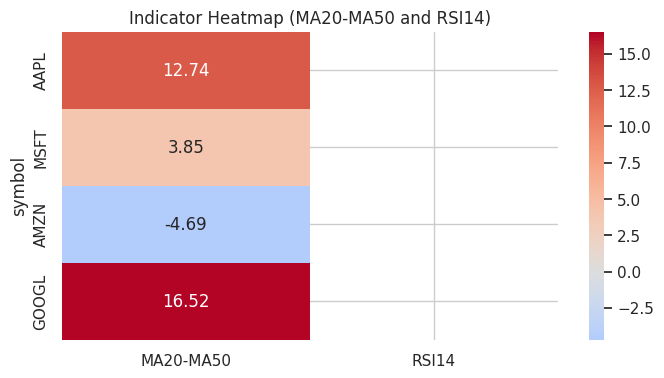

Saved: final_outputs/indicator_heatmap.png


In [ ]:

import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

# Rebuild rows defensively
rows = []
for s in symbols:
    try:
        # Try to read from previously computed 'reports' dict
        if 'reports' in globals() and reports.get(s):
            rpt = reports.get(s)
            ma20 = rpt.get('MA20', None)
            ma50 = rpt.get('MA50', None)
            rsi = rpt.get('RSI14', None) or rpt.get('RSI14', np.nan)
        else:
            # Fallback: recompute indicators
            hist_tmp = pa.fetch_history(s)
            hist_tmp = ia.add_indicators(hist_tmp)
            last = hist_tmp.dropna(subset=['MA20','MA50']).iloc[-1]
            ma20 = float(last['MA20'])
            ma50 = float(last['MA50'])
            rsi = float(last.get('RSI14', np.nan))
        rows.append({'symbol': s,
                     'MA20-MA50': None if (ma20 is None or ma50 is None) else float(ma20) - float(ma50),
                     'MA20': None if ma20 is None else float(ma20),
                     'MA50': None if ma50 is None else float(ma50),
                     'RSI14': None if rsi is None else float(rsi)})
    except Exception as e:
        # On error append NaNs so heatmap still works
        rows.append({'symbol': s, 'MA20-MA50': np.nan, 'MA20': np.nan, 'MA50': np.nan, 'RSI14': np.nan})
        print("Warning: couldn't compute indicators for", s, ":", e)

df_ind = pd.DataFrame(rows).set_index('symbol')

# Coerce to numeric and handle missing values
for col in df_ind.columns:
    df_ind[col] = pd.to_numeric(df_ind[col], errors='coerce')

# If the whole column is NaN, replace with 0 so heatmap can render
if df_ind[['MA20-MA50','RSI14']].isna().all().all():
    print("No numeric indicator data available for heatmap.")
else:
    plt.figure(figsize=(8,4))
    # Mask NaNs so annotations don't crash
    mask = df_ind[['MA20-MA50','RSI14']].isna()
    sns.heatmap(df_ind[['MA20-MA50','RSI14']].astype(float),
                annot=True, cmap='coolwarm', center=0, fmt='.2f', mask=mask)
    plt.title("Indicator Heatmap (MA20-MA50 and RSI14)")
    fname = os.path.join(OUTDIR, "indicator_heatmap.png")
    plt.savefig(fname, bbox_inches='tight', dpi=150)
    plt.show()
    print("Saved:", fname)


In [ ]:

import matplotlib.dates as mdates
OUTDIR = "final_outputs"
os.makedirs(OUTDIR, exist_ok=True)

def combined_4panel(symbol, pa, ia, save_intraday=True):
    try:
        hist = pa.fetch_history(symbol)
        hist = ia.add_indicators(hist)
    except Exception as e:
        print("Error fetching/indicators for", symbol, e)
        return
    # Prepare data
    hist = hist.dropna(subset=['MA20','MA50']).reset_index(drop=True)
    hist['signal'] = (hist['MA20'] > hist['MA50']).astype(int)
    hist['cross'] = hist['signal'].diff()
    buys = hist[hist['cross'] == 1]
    sells = hist[hist['cross'] == -1]

    # Intraday sample
    intr = None
    if save_intraday and pa.alpha_key:
        try:
            intr = pa.fetch_intraday(symbol)
            intr['Datetime'] = pd.to_datetime(intr['Datetime'])
        except Exception as e:
            intr = None

    fig, axes = plt.subplots(2,2, figsize=(16,10))
    # Price + MA
    ax = axes[0,0]
    ax.plot(hist['Date'], hist['Close'], label='Close', color='tab:blue')
    ax.plot(hist['Date'], hist['MA20'], label='MA20', color='tab:green')
    ax.plot(hist['Date'], hist['MA50'], label='MA50', color='tab:red')
    ax.set_title(f"{symbol} Price & MAs")
    ax.legend()
    ax.grid(True)
    # Signals
    ax = axes[0,1]
    ax.plot(hist['Date'], hist['Close'], label='Close', color='tab:blue')
    ax.scatter(buys['Date'], buys['Close'], marker='^', color='g', label='Buy', zorder=5)
    ax.scatter(sells['Date'], sells['Close'], marker='v', color='r', label='Sell', zorder=5)
    ax.set_title(f"{symbol} MA Crossover Signals")
    ax.legend(); ax.grid(True)
    # RSI
    ax = axes[1,0]
    ax.plot(hist['Date'], hist['RSI14'], color='orange', label='RSI14')
    ax.axhline(70, color='red', linestyle='--'); ax.axhline(30, color='green', linestyle='--')
    ax.set_title(f"{symbol} RSI (14)")
    ax.legend(); ax.grid(True)
    # Intraday
    ax = axes[1,1]
    if intr is not None and len(intr)>0:
        ax.plot(pd.to_datetime(intr['Datetime']), intr['Close'], color='purple')
        ax.set_title(f"{symbol} Intraday Sample ({len(intr)} pts)")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        for label in ax.get_xticklabels():
            label.set_rotation(45)
    else:
        ax.text(0.5,0.5,"Intraday data unavailable", ha='center', va='center', fontsize=12)
        ax.set_title(f"{symbol} Intraday")
    ax.grid(True)

    plt.tight_layout()
    fname = os.path.join(OUTDIR, f"{symbol}_4panel.png")
    fig.savefig(fname, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print("Saved:", fname)

# Run for all symbols
targets = symbols if 'symbols' in globals() else ['AAPL']
for s in targets:
    combined_4panel(s, pa, ia, save_intraday=True)


Saved: final_outputs/AAPL_4panel.png
Saved: final_outputs/MSFT_4panel.png
Saved: final_outputs/AMZN_4panel.png
Saved: final_outputs/GOOGL_4panel.png


In [ ]:
# Rolling volatility plot (21-day annualized)
for s in symbols:
    try:
        df = pa.fetch_history(s)
        df['Return'] = df['Close'].pct_change()
        df['Vol21'] = df['Return'].rolling(21).std() * (252**0.5)
        plt.figure(figsize=(10,4))
        plt.plot(df['Date'], df['Vol21'])
        plt.title(f"{s} 21-day Annualized Realized Volatility")
        plt.xlabel("Date"); plt.ylabel("Volatility")
        plt.grid(True)
        fname = os.path.join(OUTDIR, f"{s}_vol21.png")
        plt.savefig(fname, dpi=150, bbox_inches='tight')
        plt.close()
        print("Saved:", fname)
    except Exception as e:
        print("Vol plot error for", s, e)


Saved: final_outputs/AAPL_vol21.png
Saved: final_outputs/MSFT_vol21.png
Saved: final_outputs/AMZN_vol21.png
Saved: final_outputs/GOOGL_vol21.png


In [ ]:
# VWMA: Volume-weighted moving average of price over window
def vwma(df, window=20):
    pv = df['Close'] * df['Volume']
    return pv.rolling(window).sum() / df['Volume'].rolling(window).sum()

for s in symbols:
    try:
        df = pa.fetch_history(s)
        df['VWMA20'] = vwma(df, window=20)
        plt.figure(figsize=(10,4))
        plt.plot(df['Date'], df['Close'], label='Close')
        plt.bar(df['Date'], df['Volume']/df['Volume'].max()*df['Close'].max()*0.2, alpha=0.3, label='Volume (scaled)')
        plt.plot(df['Date'], df['VWMA20'], label='VWMA20', color='magenta')
        plt.title(f"{s} Close + VWMA20 + Volume")
        plt.legend(); plt.grid(True)
        fname = os.path.join(OUTDIR, f"{s}_vwma_volume.png")
        plt.savefig(fname, dpi=150, bbox_inches='tight')
        plt.close()
        print("Saved:", fname)
    except Exception as e:
        print("VWMA error for", s, e)


Saved: final_outputs/AAPL_vwma_volume.png
Saved: final_outputs/MSFT_vwma_volume.png
Saved: final_outputs/AMZN_vwma_volume.png
Saved: final_outputs/GOOGL_vwma_volume.png


In [ ]:
# Correlation matrix for daily returns
rets = {}
for s in symbols:
    try:
        df = pa.fetch_history(s)
        rets[s] = df.set_index('Date')['Close'].pct_change()
    except Exception as e:
        print("Error returns for", s, e)

rets_df = pd.DataFrame(rets)
corr = rets_df.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Daily Returns")
fname = os.path.join(OUTDIR, "returns_correlation.png")
plt.savefig(fname, dpi=150, bbox_inches='tight')
plt.close()
print("Saved:", fname)
corr


Saved: final_outputs/returns_correlation.png


,AAPL,MSFT,AMZN,GOOGL
AAPL,1.000000,0.207020,0.482951,0.352404
MSFT,0.207020,1.000000,0.482617,0.296074
AMZN,0.482951,0.482617,1.000000,0.383108
GOOGL,0.352404,0.296074,0.383108,1.000000


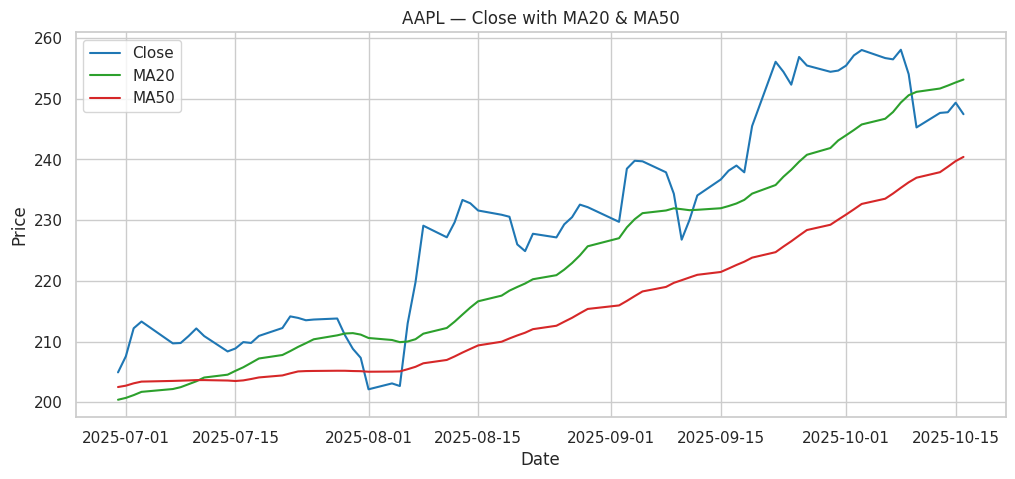

In [ ]:
def plot_price_ma(symbol, pa, ia):
    df = pa.fetch_history(symbol)
    df = ia.add_indicators(df)
    df = df.dropna(subset=['MA20','MA50']).reset_index(drop=True)
    plt.figure(figsize=(12,5))
    plt.plot(df['Date'], df['Close'], label='Close', color='tab:blue')
    plt.plot(df['Date'], df['MA20'], label='MA20', color='tab:green')
    plt.plot(df['Date'], df['MA50'], label='MA50', color='tab:red')
    plt.title(f"{symbol} — Close with MA20 & MA50")
    plt.xlabel("Date"); plt.ylabel("Price")
    plt.legend(); plt.grid(True)
    plt.show()

sym = symbols[0] if 'symbols' in globals() and len(symbols)>0 else 'AAPL'
plot_price_ma(sym, pa, ia)


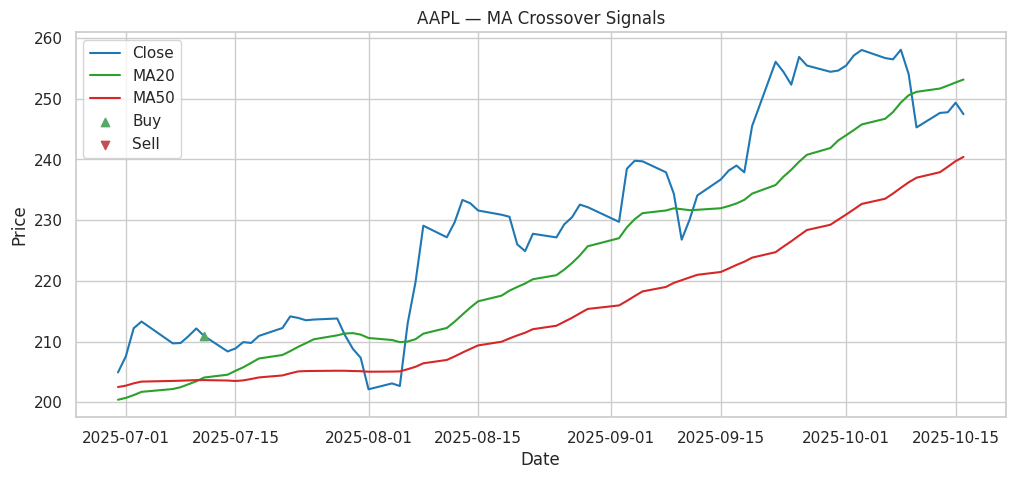

In [ ]:
def plot_ma_signals(symbol, pa, ia):
    df = pa.fetch_history(symbol)
    df = ia.add_indicators(df)
    df = df.dropna(subset=['MA20','MA50']).reset_index(drop=True)
    df['signal'] = (df['MA20'] > df['MA50']).astype(int)
    df['cross'] = df['signal'].diff()
    buys = df[df['cross'] == 1]
    sells = df[df['cross'] == -1]
    plt.figure(figsize=(12,5))
    plt.plot(df['Date'], df['Close'], label='Close', color='tab:blue')
    plt.plot(df['Date'], df['MA20'], label='MA20', color='tab:green')
    plt.plot(df['Date'], df['MA50'], label='MA50', color='tab:red')
    plt.scatter(buys['Date'], buys['Close'], marker='^', color='g', label='Buy', zorder=5)
    plt.scatter(sells['Date'], sells['Close'], marker='v', color='r', label='Sell', zorder=5)
    plt.title(f"{symbol} — MA Crossover Signals")
    plt.xlabel("Date"); plt.ylabel("Price")
    plt.legend(); plt.grid(True)
    plt.show()

plot_ma_signals(sym, pa, ia)


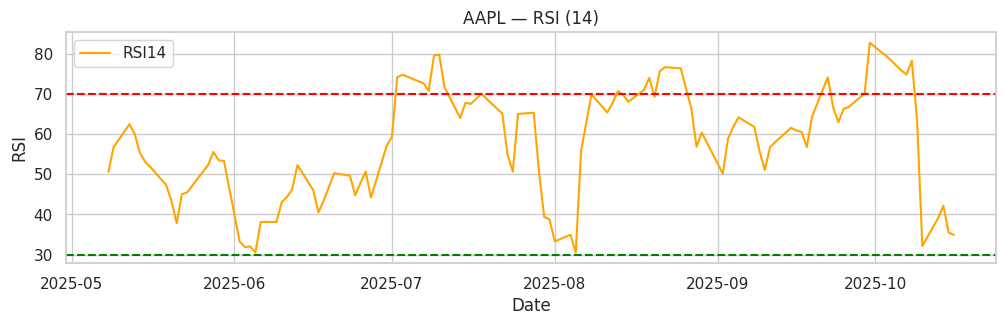

In [ ]:
def plot_rsi(symbol, pa, ia):
    df = pa.fetch_history(symbol)
    df = ia.add_indicators(df)
    plt.figure(figsize=(12,3))
    plt.plot(df['Date'], df['RSI14'], label='RSI14', color='orange')
    plt.axhline(70, color='red', linestyle='--'); plt.axhline(30, color='green', linestyle='--')
    plt.title(f"{symbol} — RSI (14)")
    plt.xlabel("Date"); plt.ylabel("RSI")
    plt.legend(); plt.grid(True)
    plt.show()

plot_rsi(sym, pa, ia)


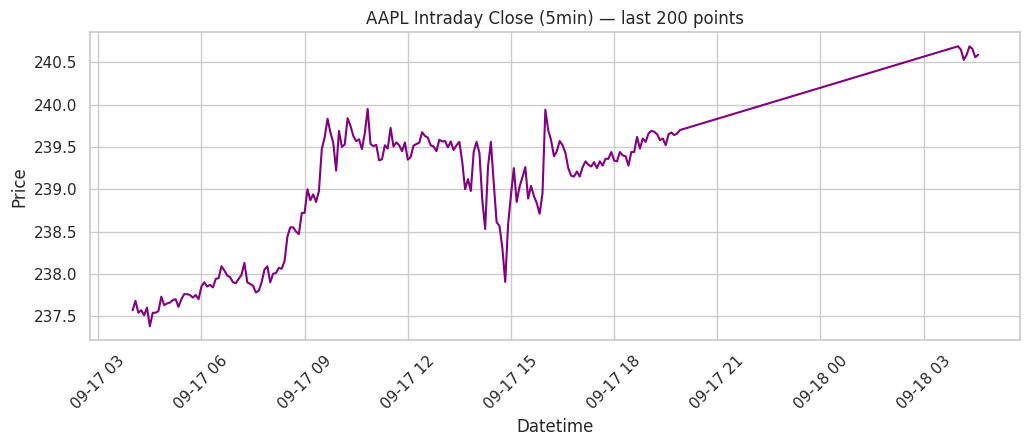

In [ ]:
def plot_intraday(symbol, pa, minutes='5min', n_points=200):
    if not getattr(pa, "alpha_key", None):
        print("Alpha Vantage key missing in PriceAgent (intraday unavailable).")
        return
    try:
        intr = pa.fetch_intraday(symbol, interval=minutes)
        intr['Datetime'] = pd.to_datetime(intr['Datetime'])
        plt.figure(figsize=(12,4))
        plt.plot(intr['Datetime'][-n_points:], intr['Close'][-n_points:], color='purple')
        plt.title(f"{symbol} Intraday Close ({minutes}) — last {min(n_points,len(intr))} points")
        plt.xlabel("Datetime"); plt.ylabel("Price"); plt.grid(True)
        plt.xticks(rotation=45)
        plt.show()
    except Exception as e:
        print("Intraday fetch error:", e)

plot_intraday(sym, pa, minutes='5min', n_points=200)


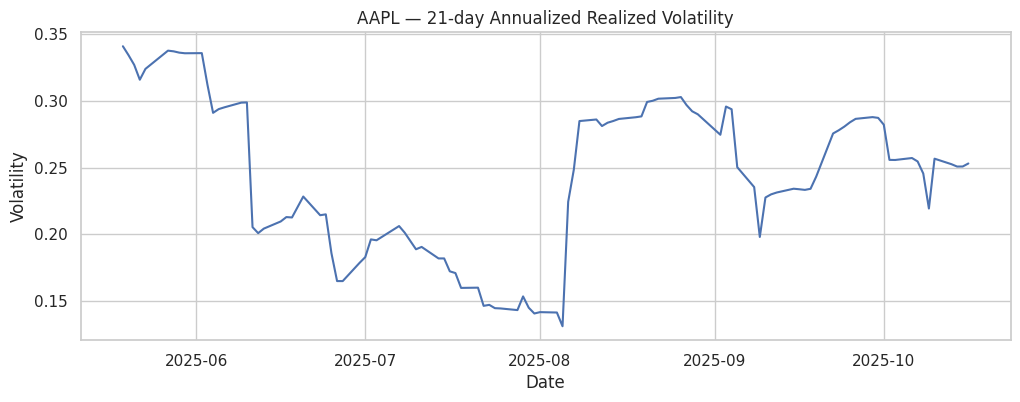

In [ ]:
def plot_volatility(symbol, pa):
    df = pa.fetch_history(symbol)
    df['Return'] = df['Close'].pct_change()
    df['Vol21'] = df['Return'].rolling(21).std() * (252**0.5)
    plt.figure(figsize=(12,4))
    plt.plot(df['Date'], df['Vol21'], label='Vol21')
    plt.title(f"{symbol} — 21-day Annualized Realized Volatility")
    plt.xlabel("Date"); plt.ylabel("Volatility")
    plt.grid(True); plt.show()

plot_volatility(sym, pa)


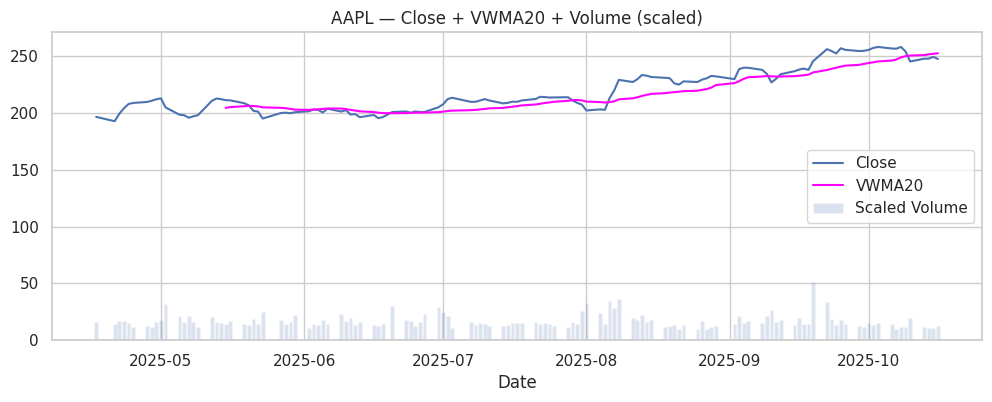

In [ ]:
def plot_vwma(symbol, pa):
    df = pa.fetch_history(symbol)
    df['VWMA20'] = (df['Close'] * df['Volume']).rolling(20).sum() / df['Volume'].rolling(20).sum()
    plt.figure(figsize=(12,4))
    plt.plot(df['Date'], df['Close'], label='Close')
    plt.plot(df['Date'], df['VWMA20'], label='VWMA20', color='magenta')
    # scaled volume bars
    scaled_vol = (df['Volume'] / df['Volume'].max()) * (df['Close'].max() * 0.2)
    plt.bar(df['Date'], scaled_vol, alpha=0.2, label='Scaled Volume')
    plt.title(f"{symbol} — Close + VWMA20 + Volume (scaled)")
    plt.xlabel("Date"); plt.legend(); plt.grid(True)
    plt.show()

plot_vwma(sym, pa)


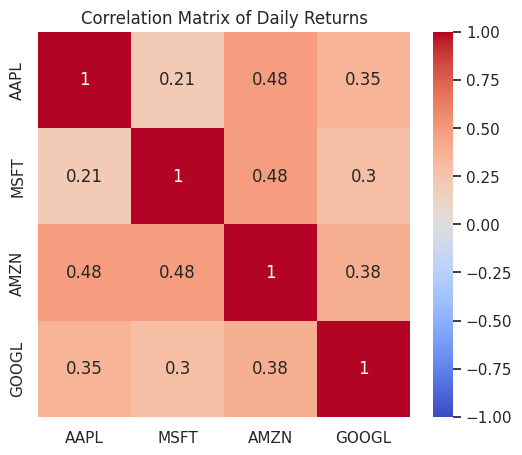

In [ ]:
def plot_returns_corr(symbols_list, pa):
    rets = {}
    for s in symbols_list:
        try:
            df = pa.fetch_history(s)
            rets[s] = df.set_index('Date')['Close'].pct_change()
        except Exception as e:
            print("Error fetching returns for", s, e)
    rets_df = pd.DataFrame(rets)
    corr = rets_df.corr()
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Correlation Matrix of Daily Returns")
    plt.show()
    return rets_df, corr

rets_df, corr = plot_returns_corr(symbols, pa)


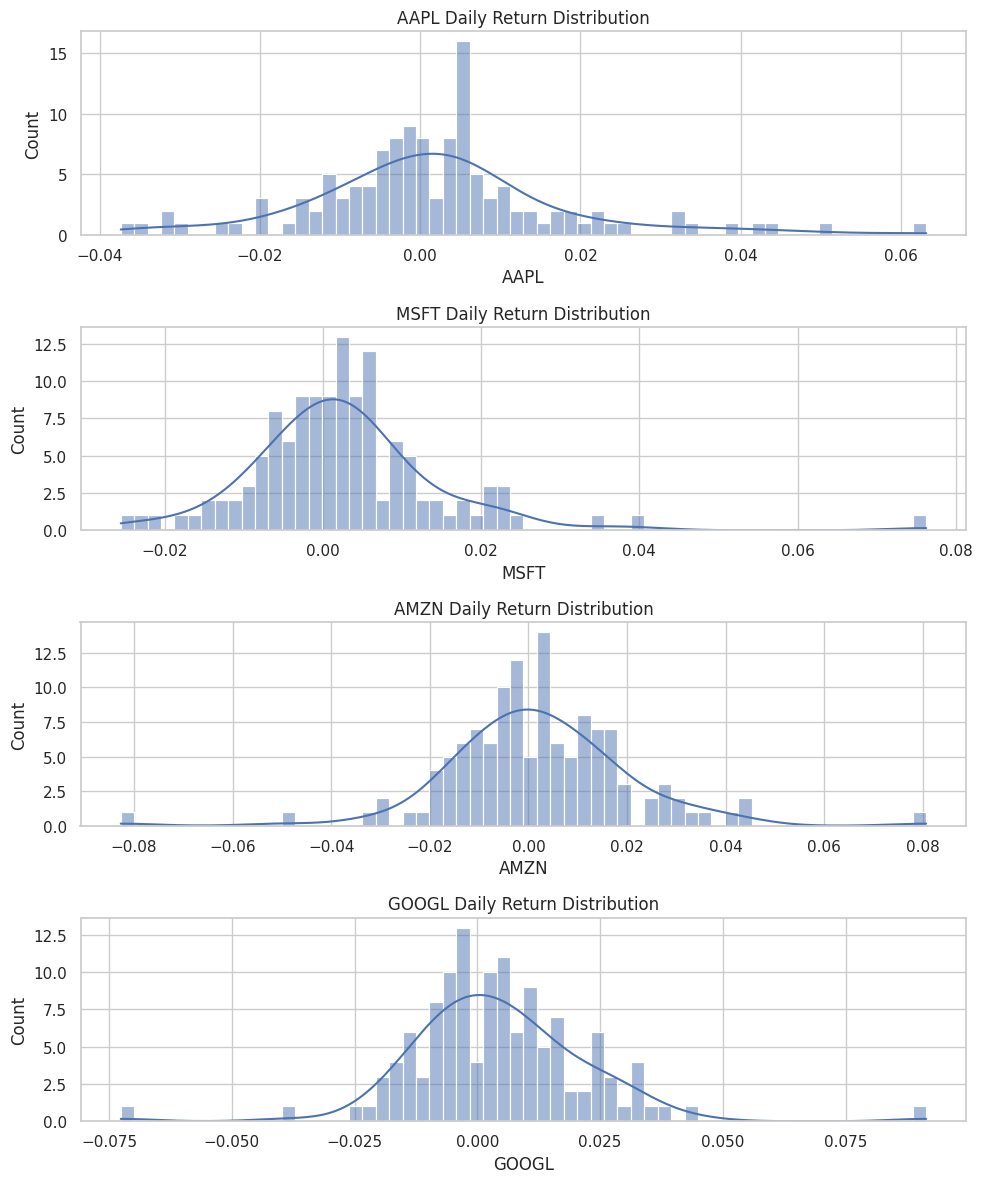

In [ ]:
def plot_return_histograms(rets_df):
    n = len(rets_df.columns)
    plt.figure(figsize=(10, 3*n))
    for i, col in enumerate(rets_df.columns):
        plt.subplot(n, 1, i+1)
        sns.histplot(rets_df[col].dropna(), bins=60, kde=True)
        plt.title(f"{col} Daily Return Distribution")
    plt.tight_layout()
    plt.show()

plot_return_histograms(rets_df)
